In [1]:
import numpy as np
from scipy.misc import imresize
import pylab
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform, filters
import sys, pylab, operator, csv
#import util
import os
import urllib

%matplotlib notebook

%load_ext autoreload
%autoreload 2

import caffe

from helpers import *
from heatmaps import *
from repro_EB_figs import *
from optimize_mask import *

In [2]:
gpu = 0
net_type = 'googlenet'

caffe.set_device(gpu)
caffe.set_mode_gpu()

net = get_net(net_type)

# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 224, 224)
conv1/7x7_s2	(10, 64, 112, 112)
pool1/3x3_s2	(10, 64, 56, 56)
pool1/norm1	(10, 64, 56, 56)
conv2/3x3_reduce	(10, 64, 56, 56)
conv2/3x3	(10, 192, 56, 56)
conv2/norm2	(10, 192, 56, 56)
pool2/3x3_s2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_0	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_1	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_3	(10, 192, 28, 28)
inception_3a/1x1	(10, 64, 28, 28)
inception_3a/3x3_reduce	(10, 96, 28, 28)
inception_3a/3x3	(10, 128, 28, 28)
inception_3a/5x5_reduce	(10, 16, 28, 28)
inception_3a/5x5	(10, 32, 28, 28)
inception_3a/pool	(10, 192, 28, 28)
inception_3a/pool_proj	(10, 32, 28, 28)
inception_3a/output	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_0	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_1	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_2	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_spl

In [3]:
labels_desc = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_words.txt', str, delimiter='\t')
synsets = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t')
(paths, labels) = read_imdb('/home/ruthfong/packages/caffe/data/ilsvrc12/annotated_train_heldout_imdb.txt')
data_desc = 'train_heldout'
paths = np.array(paths)
labels = np.array(labels)
ann_dir = '/data/ruthfong/ILSVRC2012/annotated_train_heldout_ground_truth_annotations'
ann_paths = [os.path.join(ann_dir, f) for f in os.listdir(ann_dir)]
res_dir = '/data/ruthfong/neural_coding/pycaffe_results'
mask_rel_dir = 'googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
#mask_rel_dir = 'googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
mask_paths = [os.path.join(res_dir, mask_rel_dir, '%d.npy' % x) for x in range(len(labels))]
fig_dir = '/home/ruthfong/neural_coding/paper_figures'

<IPython.core.display.Javascript object>


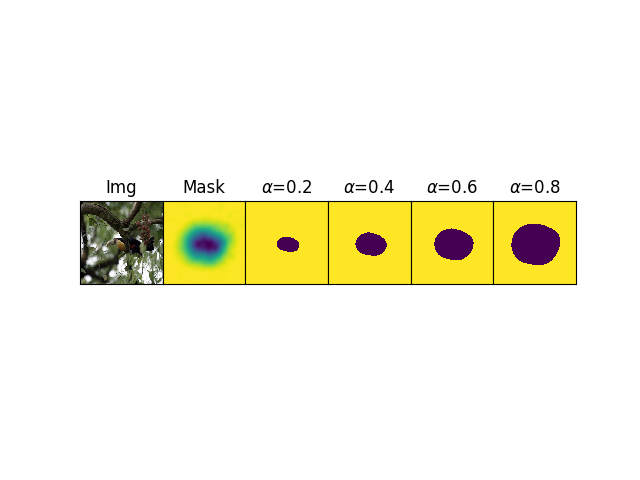

<IPython.core.display.Javascript object>


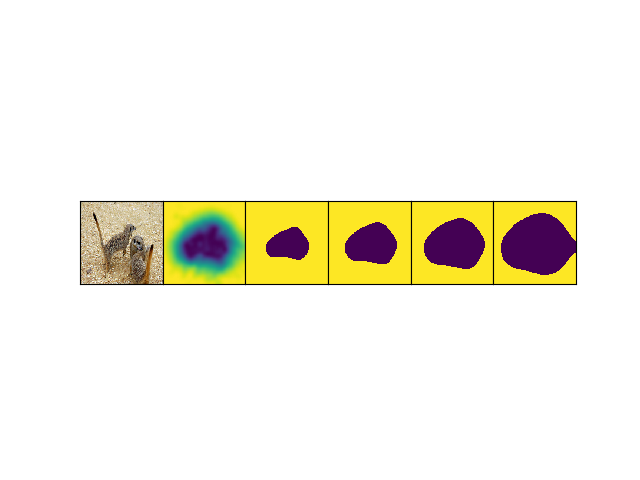

In [8]:
transformer = get_ILSVRC_net_transformer(net)
alphas = np.arange(0.2,1.0,0.2)
idx = [5,6]

for j in range(len(idx)):
    ind = idx[j]
    f, ax = plt.subplots(1,len(alphas)+2)
    #ind = idx[0]
    fig_path = os.path.join(fig_dir, 'sanity_check_test_%d.pdf' % ind)
    target = np.zeros(1000)
    target[labels[ind]] = 1
    heatmap = np.load(mask_paths[ind])
    blur_heatmap = blur(heatmap)
    blur_heatmap = (blur_heatmap-blur_heatmap.min())/(blur_heatmap.max()-blur_heatmap.min())
    img = caffe.io.load_image(paths[ind])
    img_ = transformer.preprocess('data', img)
    blur_img_ = transformer.preprocess('data', blur(img))
    constant_img_ = np.zeros(img_.shape)
    rand_img_ = np.random.random(img_.shape)*255
    null_imgs_ = [blur_img_, constant_img_, rand_img_]
    ax[0].imshow(transformer.deprocess('data', img_))
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].imshow(heatmap)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    if j == 0:
        ax[0].set_title('Img')
        ax[1].set_title('Mask')

    for i in range(len(alphas)):
        alpha = alphas[i]
        bin_heatmap = np.ones(heatmap.shape)
        bin_heatmap[blur_heatmap <= alphas[i]] = 0
        comp_img_ = img_ * bin_heatmap + blur_img_ * (1 - bin_heatmap)
        #score = forward_pass(net, comp_img_, target)
        #ax[i+1].imshow(transformer.deprocess('data', comp_img_))
        ax[i+2].imshow(bin_heatmap)
        if j == 0:
            ax[i+2].set_title(r'$\alpha$=%.1f' % alpha)
        ax[i+2].get_xaxis().set_visible(False)
        ax[i+2].get_yaxis().set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(fig_path, bbox_inches='tight', pad_inches=0.0)

<IPython.core.display.Javascript object>


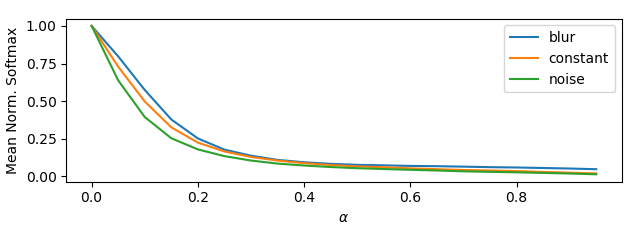

In [6]:
alphas = np.arange(0,1.0,0.05)
pylab.rcParams['figure.figsize'] = [6.4, 2.4]#4.8]
perturbations = ['blur', 'mean_img', 'random_noise']
disp_names = ['blur', 'constant', 'noise']
score_paths = ['/home/ruthfong/neural_coding/sanity_check_test/googlenet_train_heldout_%s_scores.txt' % p for p in perturbations]
scores = []
for i in range(len(score_paths)):
    scores.append(np.loadtxt(score_paths[i]))
scores = np.array(scores)
#scores[np.isnan(scores)] = 0
f, ax = plt.subplots(1,1)
for i in range(3):
    means = np.zeros(len(alphas))
    for j in range(len(alphas)):
        x = scores[i,:,j]
        x = x[np.invert(np.isnan(x))]
        x = np.maximum(0,np.minimum(x,1))
        #x = x[x >= 0]
        #x = x[x <= 1]
        #print x.shape
        means[j] = x.mean()
    ax.plot(alphas, means, label=disp_names[i])
    #ax.errorbar(alphas, means, yerr=x.std(), label=perturbations[i])
ax.legend(loc='upper right')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Mean Norm. Softmax')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'sanity_check_test_graph_shrink.pdf'), bbox_inches='tight', pad_inches=0.0)

<IPython.core.display.Javascript object>


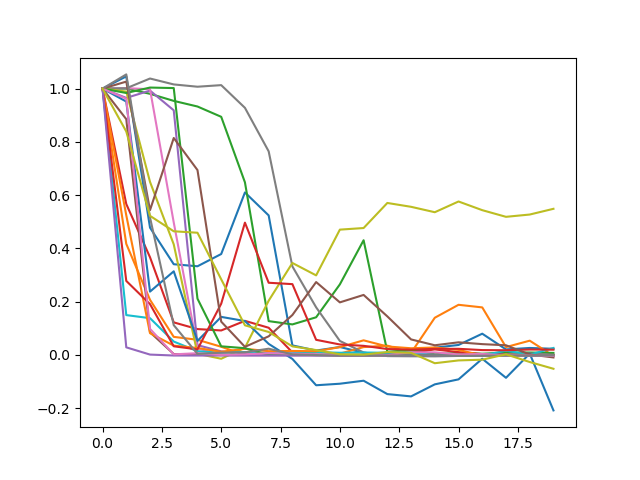

In [41]:
import time

net = get_net(net_type)
perturbation = 'blur'
transformer = get_ILSVRC_net_transformer(net)
alphas = np.arange(0,1.0,0.05)
idx = range(1,5000)
net_shape = net.blobs['data'].data.shape
all_scores = np.zeros((len(idx), len(alphas)))
start = time.time()
for j in range(len(idx)):
    if j % 50 == 0:
        start = time.time()
    ind = idx[j]
    target = np.zeros(1000)
    target[labels[ind]] = 1
    heatmap = np.load(mask_paths[ind])
    blur_heatmap = blur(heatmap)
    blur_heatmap = (blur_heatmap-blur_heatmap.min())/(blur_heatmap.max()-blur_heatmap.min())
    img = caffe.io.load_image(paths[ind])
    img_ = transformer.preprocess('data', img)
    blur_img_ = transformer.preprocess('data', blur(img))
    if perturbation == 'blur':  
        null_img_ = blur_img_
    elif perturbation == 'mean_img':
        null_img_ = np.zeros(img_.shape)
    elif perturbation == 'random_noise':
        rand_img_ = np.random.random(img_.shape)*255
    orig_score = forward_pass(net, img_, target)
    mask_score = forward_pass(net, img_ * heatmap + blur_img_ * (1 - heatmap), target)
    net.blobs['data'].reshape(len(alphas),net_shape[1], net_shape[2], net_shape[3])
    comp_imgs_ = np.zeros((len(alphas), net_shape[1], net_shape[2], net_shape[3]))
    for i in range(len(alphas)):
        alpha = alphas[i]
        bin_heatmap = np.ones(heatmap.shape)
        bin_heatmap[blur_heatmap < alphas[i]] = 0
        comp_imgs_[i,...] = img_ * bin_heatmap + null_img_ * (1 - bin_heatmap)
    net.blobs['data'].data[...] = comp_imgs_
    net.forward()
    target_scores = net.blobs['prob'].data[:,labels[ind]]
    norm_scores = (target_scores - mask_score)/float(orig_score - mask_score)
    all_scores[j] = norm_scores
    net.blobs['data'].reshape(net_shape[0],net_shape[1],net_shape[2],net_shape[3])
    if j % 50 == 0:
        print j, (time.time() - start)
f = open(out_path, 'w')
np.savetxt(f, all_scores)
f.close()
f,ax = plt.subplots(1,1)
ax.plot(np.transpose(all_scores))
#ax.plot(alphas, all_scores.mean(0))
#plt.tight_layout()

In [43]:
all_scores.shape

(19, 20)

In [ ]:
net_transformer = get_ILSVRC_net_transformer(net)
alphas = np.arange(0,1,0.05)
mask_flip = True
bb_method = 'min_max_diff'
heatmap_types = ['mask', 'saliency', 'guided_backprop', 'excitation_backprop']
num_imgs = 100
threshold = 1e-2
best_bb_sizes = np.zeros((len(heatmap_types), num_imgs))
for i in range(num_imgs):
    img = net_transformer.preprocess('data', caffe.io.load_image(paths[i]))
    null_img = net_transformer.preprocess('data', get_blurred_img(paths[i]))
    target = np.zeros(1000)
    target[labels[i]] = 1
    orig_score = forward_pass(net, img, target)
    null_score = forward_pass(net, null_img, target)
    for hh in range(len(heatmap_types)):
        h = heatmap_types[hh]
        resize = None
        if h == 'mask':
            heatmap = np.load(mask_paths[i])
            if mask_flip:
                heatmap = 1 - heatmap            
        else:
            top_name = 'loss3/classifier'
            if h == 'excitation_backprop':
                bottom_name = 'pool2/3x3_s2'
                norm_deg = -1
                resize = (224,224)
            else:
                bottom_name = 'data'
                norm_deg = np.inf
            heatmap = compute_heatmap(net, net_transformer, paths[i], labels[i], h, top_name, top_name,
                    outputBlobName = bottom_name, outputLayerName = bottom_name, norm_deg = norm_deg, gpu = gpu)
        bb_sizes = np.zeros(len(alphas))
        scores = np.zeros(len(alphas))
        for j in range(len(alphas)):
            alpha = alphas[j]
            (x0,y0,x1,y1) = getbb_from_heatmap(heatmap, alpha, method = bb_method, resize = resize)
            mask = np.ones((224,224))
            mask[y0:y1,x0:x1] = 0
            bb_size = (y1-y0)*(x1-x0)
            bb_sizes[j] = bb_size
            comp_img = img * mask + null_img * (1 - mask)
            masked_score = forward_pass(net, comp_img, target)
            scores[j] =(masked_score-null_score)/float(orig_score-null_score)
        try:
            best_i = np.where(scores <= threshold)[0][0]
        except:
            best_i = np.argmin(scores)
        best_bb_sizes[hh][i] = bb_sizes[best_i]
    print i

f = open(out_path, f)
np.savetxt(f, best_bb_sizes)
f.close()